# **W2D1 Tutorial 6: Synthesising & Interpreting Diverse Data Sources**

> Indented block

> Indented block




**Week 2, Day 1, Future Climate: The Physical Basis**

**Content creators:** Brodie Pearson (Day Lead), Julius Busecke (Tutorial co-lead), Tom Nicholas (Tutorial co-lead)

**Content reviewers:** Jenna Pearson, Ohad Zivan

**Content editors:** TBD

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

# **Tutorial Objectives**

Today's tutorials demonstrate how to work with data from *Earth System Models* (ESMs) simulations conducted for the recent *Climate Model Intercomparison Project* (CMIP6) 

By the end of today's tutorials you will be able to:

*   Manipulate raw data from multiple CMIP6 models
*   Evaluate the spread of future projections from several CMIP6 models
*   Synthesize climate data from observations and models



# **Setup**

    



In [ ]:
#Imports

!pip install condacolab &> /dev/null        
import condacolab
condacolab.install()

# Install all packages in one call (+ use mamba instead of conda)
# hopefully this improves speed
!mamba install xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xarrayutils &> /dev/null

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [ ]:
import time
tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric


In [ ]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")
# model_colors = {k:f"C{ki}" for ki, k in enumerate(source_ids)}


In [ ]:
# @title Plotting functions

# You may have functions that plot results that aren't 
# particularly interesting. You can add these here to hide them. 

def plotting_z(z):
  """This function multiplies every element in an array by a provided value

  Args:
    z (ndarray): neural activity over time, shape (T, ) where T is number of timesteps
  
   """

  fig, ax = plt.subplots()

  ax.plot(z)
  ax.set(
      xlabel='Time (s)',
      ylabel='Z',
      title='Neural activity over time'
      )



In [ ]:
# @title Helper functions

# If any helper functions you want to hide for clarity (that has been seen before
# or is simple/uniformative), add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell

def global_mean(ds:xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(['x', 'y'], keep_attrs=True) 

# Calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # for the coding exercise, ellipses will go after sel on the following line
        ref = dt[model]['historical'].ds.sel(time=slice('1950', '1980')).mean() 
        dt_out[model] = subtree - ref
    return dt_out


def plot_historical_ssp126_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ['historical', 'ssp126']:
            datasets.append(dt[model][experiment].ds.tos)

        da_combined = xr.concat(datasets, dim='time')

# **Tutorial 6: Synthesising & Interpreting Diverse Data Sources**

We are now going to reproduce the plot you created in Tutorial 4, which showed the likely range of CMIP6 simulated global mean sea surface temperature for historical and future scenario (SSP1-2.6 and SSP5-8.5) experiments. However, now we will add some an additional  dataset called *HadISST* which is an observational dataset spanning back to the 1870. Later on we will also compare to the paleo data you saw in the previous mini-lecture.


In [ ]:
# @title Video 6: Historical Context for Future Projections
#Tech team will add code to format and display the video

## **Section 6.1: Load CMIP6 SST data from several models using xarray**

Let's load the five different CMIP6 models again.



In [ ]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") # open an intake catalog containing the Pangeo CMIP cloud data

# pick our five example models
# There are many more to test out! Try executing `col.df['source_id'].unique()` to get a list of all available models
source_ids = ['IPSL-CM6A-LR', 'GFDL-ESM4', 'ACCESS-CM2', 'MPI-ESM1-2-LR', 'TaiESM1']
experiment_ids = ['historical', 'ssp126', 'ssp585']

## **If the following cell crashes, run the cell a second time**

In [ ]:
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id=source_ids,
    variable_id='tos',
    member_id='r1i1p1f1',
    table_id='Omon',
    grid_label='gn',
    experiment_id = experiment_ids,
    require_all_on = ['source_id'] #make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing, #apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(use_cftime=True), #ensure all datasets use the same time index
    storage_options={'token':'anon'} #anonymous/public authentication to google cloud storage
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt = cat.to_datatree(**kwargs)

cat_area = col.search(
    source_id=source_ids,
    variable_id='areacello', # for the coding exercise, ellipses will go after the equals on this line
    member_id='r1i1p1f1',
    table_id='Ofx', # for the coding exercise, ellipses will go after the equals on this line
    grid_label='gn',
    experiment_id = ['historical'], # for the coding exercise, ellipses will go after the equals on this line
    require_all_on = ['source_id']
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat_area.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt_area = cat_area.to_datatree(**kwargs)

dt_with_area = DataTree()

for model,subtree in dt.items():
    metric = dt_area[model]['historical'].ds['areacello']
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric,metric)

    %matplotlib inline

# average every dataset in the tree globally
dt_gm = dt_with_area.map_over_subtree(global_mean)

for experiment in ['historical', 'ssp126', 'ssp585']:
    da = dt_gm['TaiESM1'][experiment].ds.tos
    da.plot(label=experiment)
plt.title('Global Mean SST from TaiESM1')
plt.ylabel('Global Mean SST [$^\circ$C]')
plt.xlabel('Year')
plt.legend()
 
plot_historical_ssp126_combined(dt_gm)

dt_gm_anomaly = datatree_anomaly(dt_gm)

plot_historical_ssp126_combined(dt_gm_anomaly)

plt.close()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



### **Coding Exercise 6.1: Create a single-model ensemble data with IPCC uncertainty bands**

Complete the following code to:


1.  Calculate a time series of the global mean sea surface temperature (GMSST) from the HadISST dataset
2.  Subtract a base period from the HadISST GMSST time series. Use the same base series as the CMIP6 timeseries you are comparing against. 

In [ ]:
#################################################
## TODO for students: details of what they should do ##
# Fill out function and remove
raise NotImplementedError("Student exercise: Process the HadISST dataset to approproately compare to the CMIP6 data you have already processed")
#################################################
%matplotlib inline

for experiment, color in zip(['historical', 'ssp126', 'ssp585'], ['C0', 'C1', 'C2']):
    datasets = []
    for model in dt_gm_anomaly.keys():
        annual_sst = dt_gm_anomaly[model][experiment].ds.tos.coarsen(time=12).mean().assign_coords(source_id=model)
        datasets.append(annual_sst.sel(time=slice(None, '2100')).load()) # the french model has a long running member for ssp 126 (we could change the model to keep this clean)
    da = xr.concat(datasets, dim='source_id', join='override').squeeze()
    x = da.time.data
    da_lower = da.squeeze().quantile(0.17, dim='source_id')
    da_upper = da.squeeze().quantile(0.83, dim='source_id')
    plt.fill_between(x, da_lower, da_upper,  alpha=0.5, color=color)
    da.mean('source_id').plot(color=color, label=experiment,)

# But now add observations (https://pangeo-forge.org/dashboard/feedstock/43)
store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/HadISST-feedstock/hadisst.zarr'
ds_obs = xr.open_dataset(store, engine='zarr', chunks={}).convert_calendar('standard', use_cftime=True)
# mask missing values
ds_obs = ds_obs.where(ds_obs>-1000)
weights = np.cos(np.deg2rad(ds_obs.latitude)) #In a regular lon/lat grid, area is ~cos(latitude)
# Calculate weighted global mean for observations
sst_obs_gm = ...
# Calculate anomaly for observations
sst_obs_gm_anomaly = ...

# plot observations
sst_obs_gm_anomaly.coarsen(time=12, boundary='trim').mean().plot(color='0.3', label='Observations')
plt.ylabel('Global Mean SST with respect to 1950-1980')
plt.xlabel('Year')
plt.legend()

plt.show()

NotImplementedError: ignored

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
fin

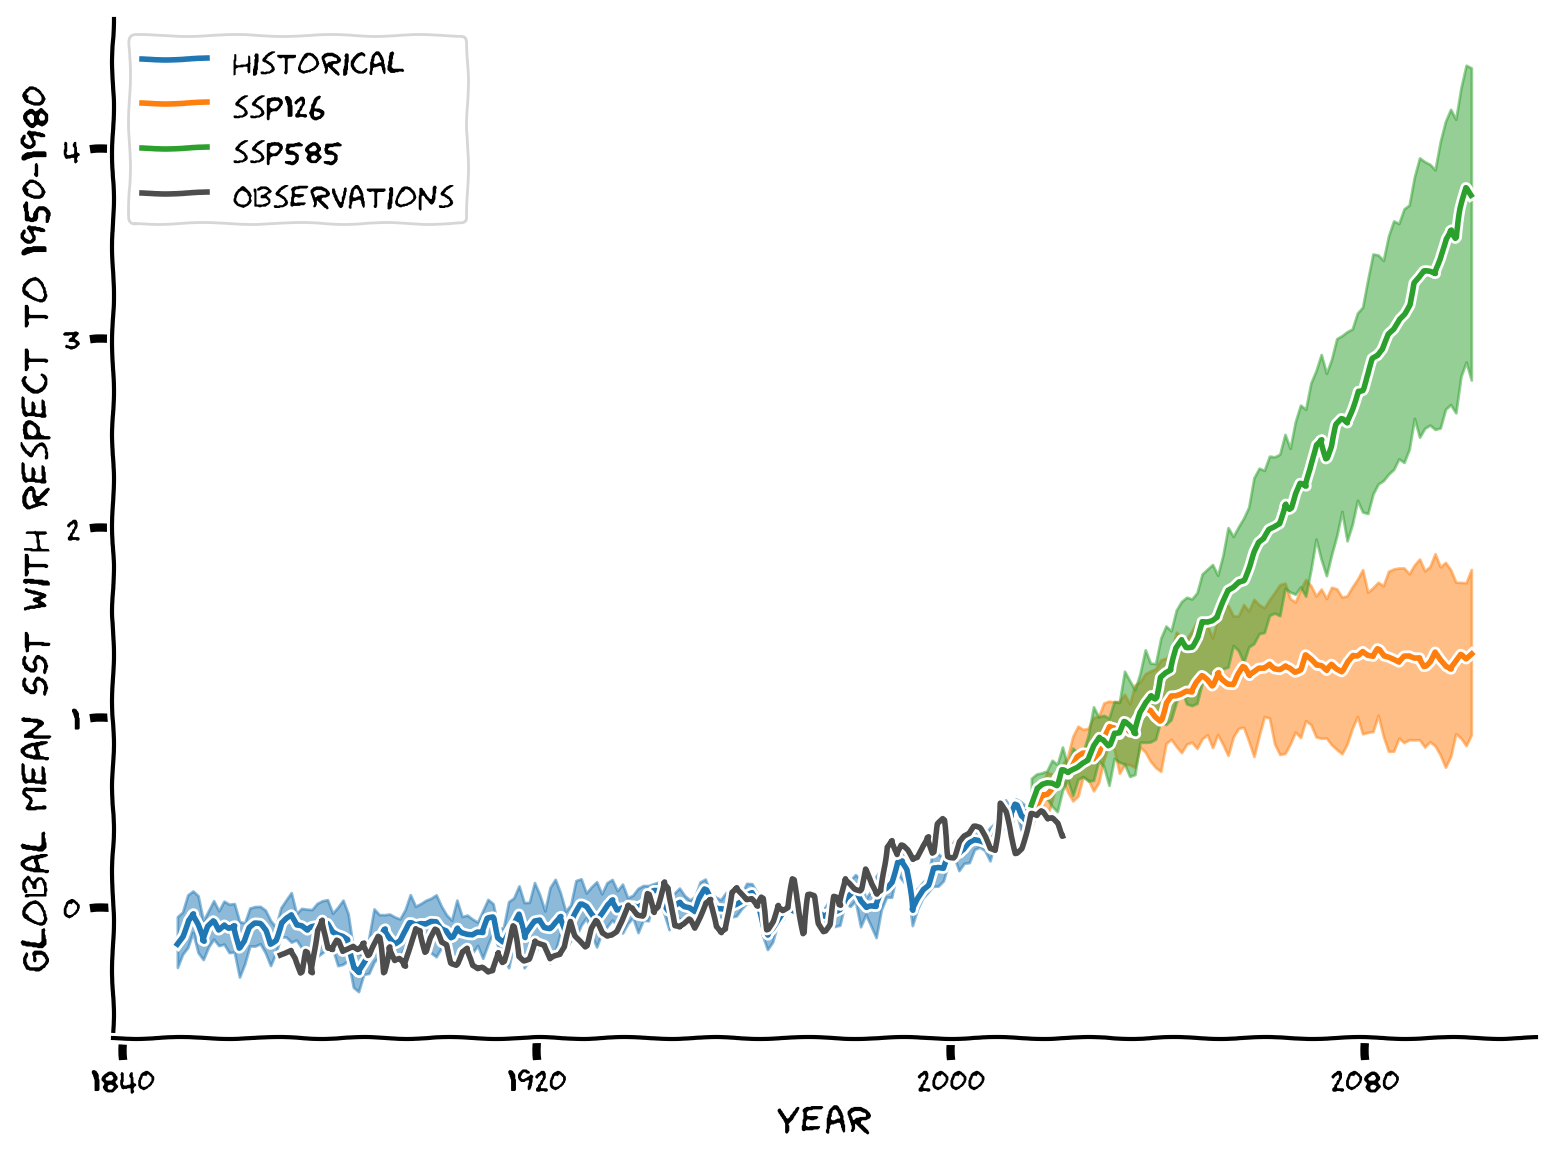

In [ ]:
# to_remove solution
%matplotlib inline

with plt.xkcd():
  for experiment, color in zip(['historical', 'ssp126', 'ssp585'], ['C0', 'C1', 'C2']):
      datasets = []
      for model in dt_gm_anomaly.keys():
          annual_sst = dt_gm_anomaly[model][experiment].ds.tos.coarsen(time=12).mean().assign_coords(source_id=model)
          datasets.append(annual_sst.sel(time=slice(None, '2100')).load()) # the french model has a long running member for ssp 126 (we could change the model to keep this clean)
      da = xr.concat(datasets, dim='source_id', join='override').squeeze()
      x = da.time.data
      da_lower = da.squeeze().quantile(0.17, dim='source_id')
      da_upper = da.squeeze().quantile(0.83, dim='source_id')
      plt.fill_between(x, da_lower, da_upper,  alpha=0.5, color=color)
      da.mean('source_id').plot(color=color, label=experiment,)
  
  # But now add observations (https://pangeo-forge.org/dashboard/feedstock/43)
  store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/HadISST-feedstock/hadisst.zarr'
  ds_obs = xr.open_dataset(store, engine='zarr', chunks={}).convert_calendar('standard', use_cftime=True)
  # mask missing values
  ds_obs = ds_obs.where(ds_obs>-1000)
  weights = np.cos(np.deg2rad(ds_obs.latitude)) #In a regular lon/lat grid, area is ~cos(latitude)
  # Calculate weighted global mean for observations
  sst_obs_gm = ds_obs.sst.weighted(weights).mean(['longitude', 'latitude'])
  # Calculate anomaly for observations
  sst_obs_gm_anomaly = sst_obs_gm - sst_obs_gm.sel(time=slice('1950', '1980')).mean()
  
  # plot observations
  sst_obs_gm_anomaly.coarsen(time=12, boundary='trim').mean().plot(color='0.3', label='Observations')
  plt.ylabel('Global Mean SST with respect to 1950-1980')
  plt.xlabel('Year')
  plt.legend()
  
  plt.show()

## Post-figure question

Now that you have a modern and projected time series containing models and observations,
1. What context and/or validation of the simulations does this information provide?
2. What additional context/validation can you glean by also considering the paleo proxy infromation in the figure below? (This figure ch was also shown in the last video)

Note the paleo periods on this figure represent the Mid-Pleiocene Warm Period (MPWP), the Last Inter-glacial (LIG) and the Last Glacial Maximum (LGM)

<div>
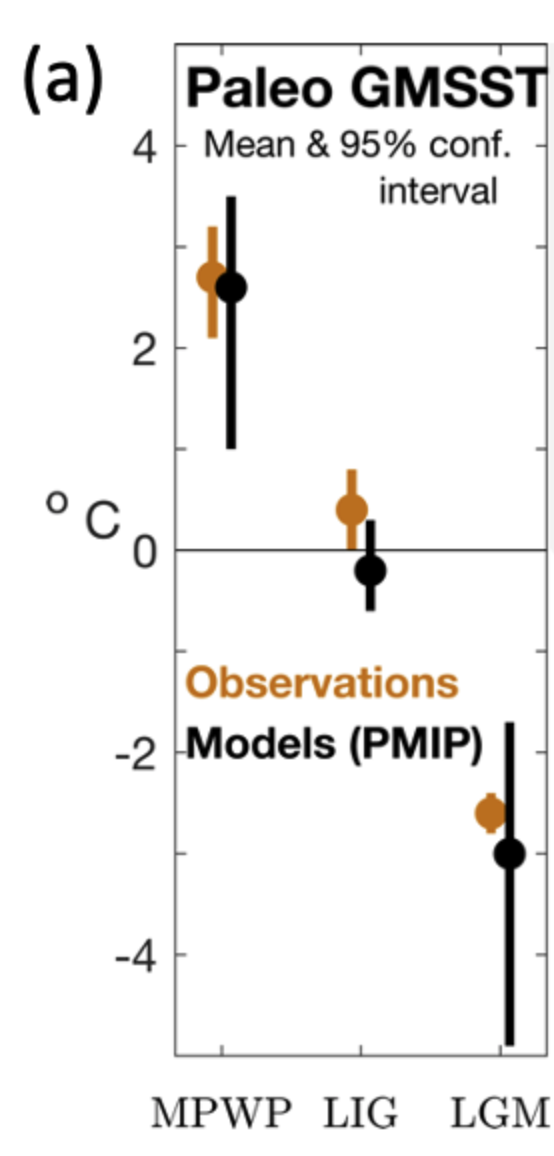
</div>

This image shows part of panel a) from Figure 9.3 from the IPCC AR6 WG1 report. This figure has the following caption: **Figure 9.3** | Sea surface temperature (SST) and its changes with time. (a) Time series of global mean SST anomaly relative to 1950–1980 climatology. Shown are paleoclimate reconstructions and PMIP models, observational reanalyses (HadISST) and multi-model means from the Coupled Model Intercomparison Project (CMIP) historical simulations, CMIP projections, and HighResMIP experiment. (b) Map of observed SST (1995–2014 climatology HadISST). (c) Historical SST changes from observations. (d) CMIP 2005–2100 SST change rate. (e) Bias of CMIP. (f) CMIP change rate. (g) 2005–2050 change rate for SSP5-8.5 for the CMIP ensemble. (h) Bias of HighResMIP (bottom left) over 1995–2014. (i) HighResMIP change rate for 1950–2014. (j) 2005–2050 change rate for SSP5-8.5 for the HighResMIP ensemble. No overlay indicates regions with high model agreement, where ≥80% of models agree on sign of change. Diagonal lines indicate regions with low model agreement, where <80% of models agree on sign of change (see Cross-Chapter Box Atlas.1 for more information). Further details on data sources and processing are available in the chapter data table (Table 9.SM.9).


<div>
<img src="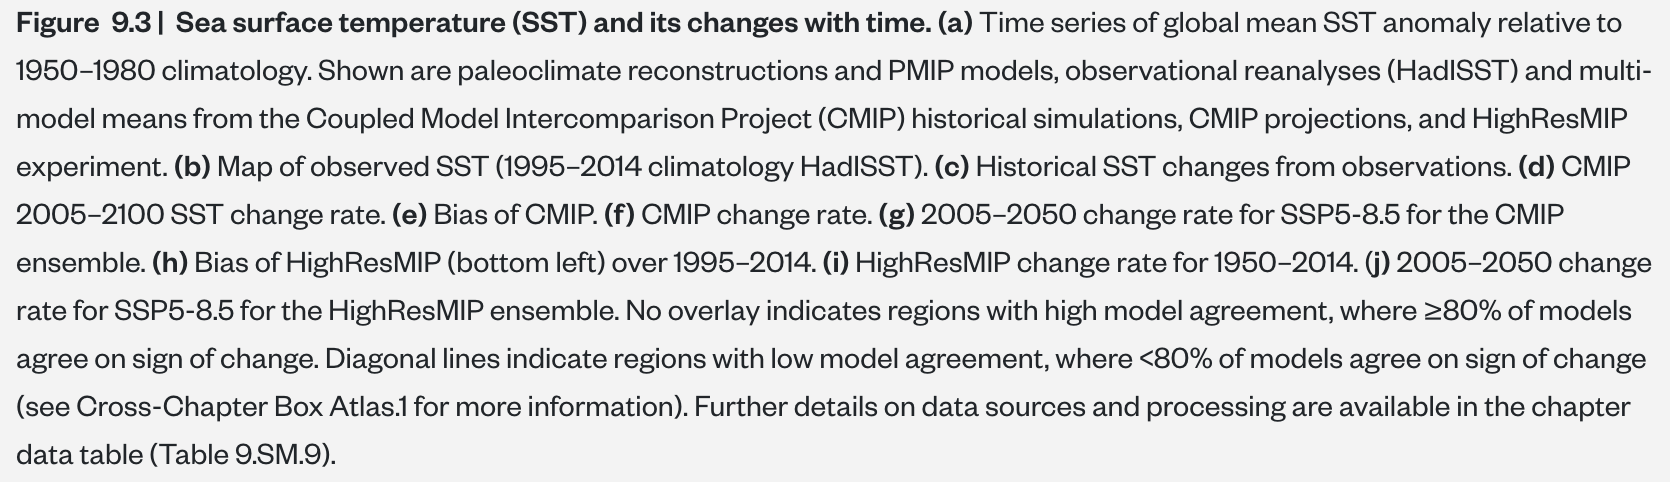)" width="200"/>
</div>

## **Outro**

Great job getting through today's tutorials and learning to work with CMIP6 data - you now have the tools to explore countless questions about future physical changes in climate!

In the next day's tutorials you will start to look at the socio-economic side of future changes in Earth's climate. This can take many forms, from the design of SSPs (*Which socio-economic future scenarios are realistic and how would they affect through future climate forcing?*) to the impacts that a changing climate has on society. Keep these physical/socio-economic links in your mind as you move through the next tutorials!

